In [49]:
import os
import pandas as pd
from pandas import DataFrame
from keras.models import Sequential, Model, Sequential, load_model, Input
from keras.layers import Dense, Input, Activation, Conv2D, MaxPool2D, Flatten, UpSampling2D, Conv2DTranspose, Reshape, LeakyReLU, Concatenate
from keras.optimizers import Adam
from keras.layers import Dropout
from keras.layers import BatchNormalization
from keras.utils import np_utils, plot_model
from keras import backend as K
import matplotlib.pyplot as plt
# matplotlib.use("TkAgg")
%matplotlib inline
import numpy as np
np.random.seed(1)
from PIL import Image
import random
import math
from sklearn.metrics import confusion_matrix

In [50]:
if not os.path.exists('model/'):
    os.makedirs('model/')

In [51]:
from keras.datasets import cifar10
(X_train, y_train), (X_test, y_test)=cifar10.load_data()
print('x_train\n', X_train.shape)
print('y_train\n', y_train.shape, y_train[0])
print('x_test\n', X_test.shape)
print('y_test\n', y_test.shape)

x_train
 (50000, 32, 32, 3)
y_train
 (50000, 1) [6]
x_test
 (10000, 32, 32, 3)
y_test
 (10000, 1)


In [52]:
digit_size = 32
channels = 3

# data pre-processing
X_train = X_train.astype('float32') / 255       # minmax_normalized
X_test = X_test.astype('float32') / 255         # minmax_normalized
X_train = X_train.reshape((-1, digit_size, digit_size, channels))
X_test = X_test.reshape((-1, digit_size, digit_size, channels))
print(X_train.shape)
print(X_test.shape)

(50000, 32, 32, 3)
(10000, 32, 32, 3)


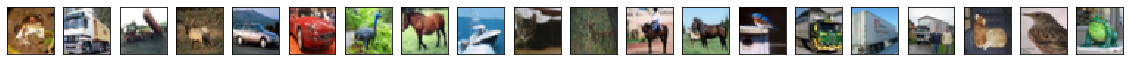

In [78]:
n = 20
plt.figure(figsize=(20, 4))
for i in range(n):
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(X_train[i].reshape(digit_size, digit_size, channels), cmap='binary')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [53]:
input_img = Input(shape=(digit_size, digit_size, channels))  # adapt this if using `channels_first` image data format

x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPool2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = MaxPool2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPool2D((2, 2), padding='same')(x)
# at this point the representation is (4, 4, 8) i.e. 128-dimensional
input_ec = Input(shape=(4, 4, 8)) 
x = Conv2D(8, (3, 3), activation='relu', padding='same')(input_ec)
x = UpSampling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(channels, (3, 3), activation='sigmoid', padding='same')(x)
encoder = Model(inputs=input_img, outputs=encoded)
decoder = Model(input_ec, decoded)

# del encoder
# encoder = load_model('model/encoder.h5')
# del decoder
# decoder = load_model('model/decoder.h5')

ec_out = encoder(input_img)
dc_out = decoder(ec_out)
autoencoder = Model(input_img, dc_out)

autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

encoder.summary()
decoder.summary()
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_25 (InputLayer)        (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_85 (Conv2D)           (None, 32, 32, 16)        448       
_________________________________________________________________
max_pooling2d_37 (MaxPooling (None, 16, 16, 16)        0         
_________________________________________________________________
conv2d_86 (Conv2D)           (None, 16, 16, 8)         1160      
_________________________________________________________________
max_pooling2d_38 (MaxPooling (None, 8, 8, 8)           0         
_________________________________________________________________
conv2d_87 (Conv2D)           (None, 8, 8, 8)           584       
_________________________________________________________________
max_pooling2d_39 (MaxPooling (None, 4, 4, 8)           0         
Total para

In [64]:
# training
autoencoder.fit(X_train, X_train, epochs=10, batch_size=256, shuffle=True)

encoder.save('model/encoder.h5')
decoder.save('model/decoder.h5')

Epoch 1/10
50000/50000 [==============================] - 28s 560us/step - loss: 0.5964
Epoch 2/10
50000/50000 [==============================] - 28s 558us/step - loss: 0.5950
Epoch 3/10
50000/50000 [==============================] - 29s 577us/step - loss: 0.5938
Epoch 4/10
50000/50000 [==============================] - 29s 574us/step - loss: 0.5930
Epoch 5/10
50000/50000 [==============================] - 29s 579us/step - loss: 0.5924
Epoch 6/10
50000/50000 [==============================] - 29s 589us/step - loss: 0.5918
Epoch 7/10
50000/50000 [==============================] - 28s 564us/step - loss: 0.5912
Epoch 8/10
50000/50000 [==============================] - 32s 631us/step - loss: 0.5909
Epoch 9/10
50000/50000 [==============================] - 30s 606us/step - loss: 0.5905
Epoch 10/10
50000/50000 [==============================] - 29s 580us/step - loss: 0.5899


(10, 32, 32, 3)


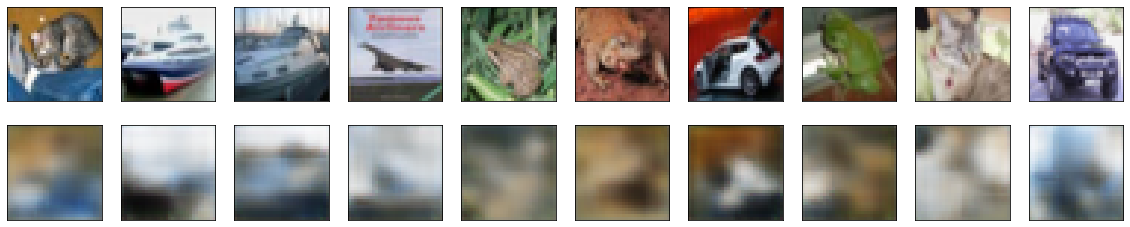

In [74]:
n = 10
decoded_imgs = autoencoder.predict(X_test[:n])
print(decoded_imgs.shape)
  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(X_test[i].reshape(digit_size, digit_size, channels), cmap='binary')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(digit_size, digit_size, channels), cmap='binary')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

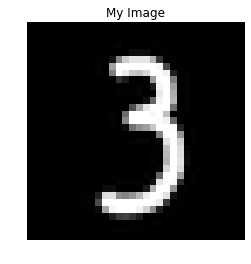

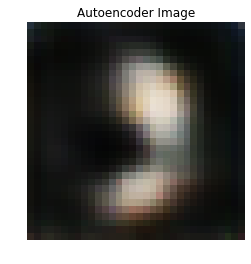

In [75]:
from PIL import Image
im = Image.open("./media/n_3.png")
im = im.resize((digit_size, digit_size), Image.ANTIALIAS) # resize the image
im = np.array(im) #convert to an array
im2 = im.astype('float32') / 255 # normalise input
# 畫圖
plt.imshow(im2, cmap='gray')
plt.title('My Image')
plt.axis('off')
plt.show()

test_image = np.reshape(im2, [1, digit_size, digit_size, channels]) # reshape it to our input placeholder shape
d_ = autoencoder.predict(test_image)
# 畫圖
plt.imshow(np.reshape(d_, (digit_size, digit_size, channels)))
plt.title('Autoencoder Image')
plt.axis('off')
plt.show()